In [1]:
!pip install -q pybaseball pandas numpy scikit-learn matplotlib seaborn



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install -q pybaseball --upgrade



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [3]:
from pybaseball import statcast, cache, batting_stats
import warnings
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
warnings.filterwarnings('ignore', category=FutureWarning)
cache.enable()
print("Initiating Download for all Statcast Data(will take some time due to amount of data)")
data = statcast(start_dt="2024-04-01", end_dt="2024-09-01")


Initiating Download for all Statcast Data(will take some time due to amount of data)
This is a large query, it may take a moment to complete


100%|██████████| 154/154 [01:25<00:00,  1.81it/s]


In [5]:
print("\nSample of Statcast Data")
print(data.head())
print("\nAll Columns(features) in Dataset:")
print(data.columns.tolist())


Sample of Statcast Data
     pitch_type  game_date  release_speed  release_pos_x  release_pos_z  \
1674         FF 2024-09-01           87.8          -3.46           5.87   
1716         SI 2024-09-01           90.0          -3.07           5.91   
1766         FF 2024-09-01           87.1          -3.57            5.8   
1781         FF 2024-09-01           87.3          -3.34           5.79   
1835         SI 2024-09-01           86.7          -3.25           5.94   

       player_name  batter  pitcher     events    description  ...  \
1674  Floro, Dylan  681624   571670  strikeout  called_strike  ...   
1716  Floro, Dylan  681624   571670       None           ball  ...   
1766  Floro, Dylan  681624   571670       None           foul  ...   
1781  Floro, Dylan  681624   571670       None  called_strike  ...   
1835  Floro, Dylan  500743   571670  field_out  hit_into_play  ...   

      n_thruorder_pitcher  n_priorpa_thisgame_player_at_bat  \
1674                    1               

In [6]:
colsofInterest = ['player_name', 'launch_speed', 'launch_angle', 'events', 'batter']

if all(col in data.columns for col in colsofInterest):
    dataframe = data[colsofInterest].copy()
else:
    raise ValueError("At least 1 column is missing from the dataset")


dataframe = dataframe.rename(columns={'launch_speed': 'exit_velocity'})
dataframe = dataframe.dropna(subset=['exit_velocity', 'launch_angle'])

eventsOfMeaning = ['single', 'double', 'triple', 'home_run']
dataframe = dataframe[dataframe['events'].isin(eventsOfMeaning)]

dataframe['barrel'] = ((dataframe['exit_velocity'] >= 98) & (dataframe['launch_angle'].between(26, 30))).astype(int)

dataframe['plate_appearance'] = 1

print("\nSample Dataset with 'barrel' and 'plate_appearance' columns:")
print(dataframe.head())



Sample Dataset with 'barrel' and 'plate_appearance' columns:
             player_name  exit_velocity  launch_angle  events  batter  barrel  \
2065        Floro, Dylan           87.6            14  single  605131       0   
2819  Hernández, Enrique           94.0            13  single  545341       0   
3016  Hernández, Enrique           95.6            17  single  641645       0   
3215  Hernández, Enrique           90.3            14  double  678489       0   
3996  Hernández, Enrique           96.0             8  single  682998       0   

      plate_appearance  
2065                 1  
2819                 1  
3016                 1  
3215                 1  
3996                 1  


In [7]:

aggregatedDataframe = dataframe.groupby('player_name').agg({ 'exit_velocity': 'mean', 'launch_angle': 'mean', 'barrel': 'mean',
    'events': lambda x: (x == 'home_run').sum(), 'plate_appearance': 'sum'  }).rename(columns={
    'events': 'home_runs','plate_appearance': 'plate_appearances'}).reset_index()

print("\nSample of Aggregated Player Metrics:")
print(aggregatedDataframe)




Sample of Aggregated Player Metrics:
         player_name  exit_velocity  launch_angle    barrel  home_runs  \
0     Abbott, Andrew      92.093701     12.937008  0.070866         25   
1       Abreu, Bryan      93.598039      9.509804  0.000000          5   
2        Adam, Jason      93.557576     14.272727  0.121212          5   
3      Adams, Austin      91.148649     14.540541  0.027027          4   
4         Adcock, Ty      98.228571     20.428571  0.142857          4   
..               ...            ...           ...       ...        ...   
792     Zerpa, Angel      96.964815      3.388889  0.055556          6   
793     Zuber, Tyler     102.366667     20.333333  0.000000          1   
794  Zulueta, Yosver     100.938462      6.153846  0.000000          1   
795   Zuñiga, Guillo           93.1          -2.2  0.000000          0   
796   de Geus, Brett      92.445455     12.545455  0.000000          0   

     plate_appearances  
0                  127  
1                   51 

In [8]:
features = ['exit_velocity', 'launch_angle', 'barrel']

X = aggregatedDataframe[features]
y = aggregatedDataframe['home_runs'] / aggregatedDataframe['plate_appearances']

polyexpo = PolynomialFeatures(degree=2, include_bias=False)
X_poly = polyexpo.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)
model = Lasso(alpha=0.1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\nModel Evaluations:")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R^2: {r2:.3f}")


Model Evaluations:
MSE: 0.01
MAE: 0.07
R^2: 0.436


In [9]:
predictedDataframe = pd.DataFrame({'Player': aggregatedDataframe.iloc[y_test.index]['player_name'].values,
    'Actual HR rate': y_test.values,
    'Predicted HR rate': y_pred,
    'Actual HRs': aggregatedDataframe.iloc[y_test.index]['home_runs'].values 
})

predictedDataframe['Predicted HRs'] = np.round(predictedDataframe['Predicted HR rate'] * aggregatedDataframe.iloc[y_test.index]['plate_appearances'].values, 1)
predictedDataframe = predictedDataframe.sort_values(by='Player')

print("\nSample Predictions (Alphabetical):")
print(predictedDataframe[['Player', 'Actual HR rate', 'Actual HRs', 'Predicted HRs']])



Sample Predictions (Alphabetical):
                  Player  Actual HR rate  Actual HRs  Predicted HRs
151          Adam, Jason        0.151515           5            6.0
144         Akin, Keegan        0.148936           7            6.1
113     Alexander, Scott        0.090909           2            2.0
35       Anderson, Tyler        0.152174          21           22.0
127         Ashby, Aaron        0.222222           2            0.8
..                   ...             ...         ...            ...
86     Wrobleski, Justin        0.290323           9            7.0
67   Yamamoto, Yoshinobu        0.107143           6            7.5
72          Zerpa, Angel        0.111111           6            4.3
38          Zuber, Tyler        0.333333           1            0.9
156       Zuñiga, Guillo        0.000000           0            0.1

[160 rows x 4 columns]


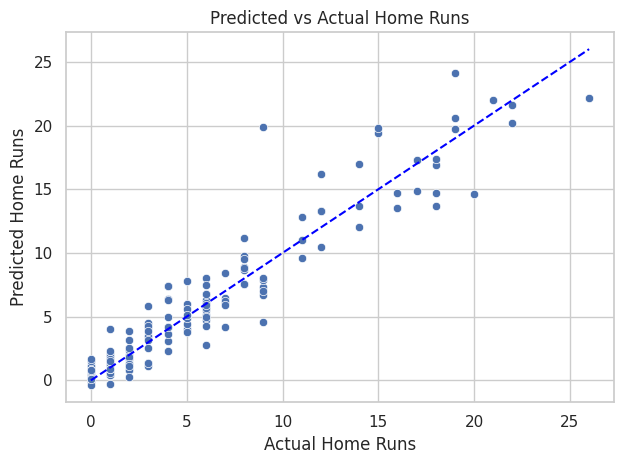

In [10]:
sns.set(style="whitegrid")
sns.scatterplot(x='Actual HRs', y='Predicted HRs', data=predictedDataframe)

findMax = max(predictedDataframe['Actual HRs'].max(), predictedDataframe['Predicted HRs'].max())
plt.plot([0, findMax], [0, findMax], color='blue', linestyle='--')

plt.title("Predicted vs Actual Home Runs")
plt.xlabel("Actual Home Runs")
plt.ylabel("Predicted Home Runs")
plt.tight_layout()
plt.show()


In [11]:
features = ['exit_velocity', 'launch_angle', 'barrel']
X = aggregatedDataframe[features]

poly = PolynomialFeatures(degree=2, include_bias=False)
XFull = poly.fit_transform(X)

y = aggregatedDataframe['home_runs'] / aggregatedDataframe['plate_appearances']  
model = Lasso(alpha=0.1)
model.fit(XFull, y)
yFull = model.predict(XFull)
predictedHomeruns = np.round(yFull * aggregatedDataframe['plate_appearances'], 1)

aggregatedDataframe['Predicted_HRs'] = predictedHomeruns
aggregatedDataframe['HR_rate'] = y 

aggregatedDataframe = aggregatedDataframe.sort_values(by='player_name')
print("\nFull Dataset of Predicted HRs and HR Rate for each Player:")
print(aggregatedDataframe[['player_name', 'HR_rate','home_runs', 'Predicted_HRs']])





Full Dataset of Predicted HRs and HR Rate for each Player:
         player_name   HR_rate  home_runs  Predicted_HRs
0     Abbott, Andrew  0.196850         25           18.4
1       Abreu, Bryan  0.098039          5            5.2
2        Adam, Jason  0.151515          5            6.0
3      Adams, Austin  0.108108          4            5.4
4         Adcock, Ty  0.571429          4            2.1
..               ...       ...        ...            ...
792     Zerpa, Angel  0.111111          6            4.7
793     Zuber, Tyler  0.333333          1            0.9
794  Zulueta, Yosver  0.076923          1            1.5
795   Zuñiga, Guillo  0.000000          0            0.1
796   de Geus, Brett  0.000000          0            1.4

[797 rows x 4 columns]


In [ ]:
inputPerson = input("Input a player name (e.g., Abbott, Andrew): ")

player = aggregatedDataframe[aggregatedDataframe['player_name'].str.lower() == inputPerson.lower()]

if player.empty:
    print("Player is not in the Dataset! Please enter another player!")
else:
    inputX = player[['exit_velocity', 'launch_angle', 'barrel']]
    inputPolyX = poly.transform(inputX) 
    predHrRate = model.predict(inputPolyX)[0]
    playerName = player['player_name'].values[0]
    numAppearances = player['plate_appearances'].values[0]
    predictedHRs = np.round(predHrRate * numAppearances, 1)
    print(f"\nPredicted Home Runs for {playerName}: {predictedHRs:.1f}")

